In [8]:
from blackjackenv import BlackjackEnv
# load config
import gymnasium as gym
import neat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import neatHelpers
config_file = './config-feedforward.txt'


In [ ]:
generations = 200

# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

pe = neat.ParallelEvaluator(10, neatHelpers.eval_genomes)
# Run the simulation
winner = p.run(pe.evaluate, generations)

# show final stats
print('\nBest genome:\n{!s}'.format(winner))


 ****** Running generation 0 ****** 
Population's average fitness: 466.84000 stdev: 352.16830
Best fitness: 855.50000 - size: (1, 3) - species 1 - id 13
Average adjusted fitness: 0.546
Mean genetic distance 1.178, standard deviation 0.432
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50    855.5    0.546     0
Total extinctions: 0
Generation time: 3.333 sec

 ****** Running generation 1 ****** 
Population's average fitness: 616.18000 stdev: 305.39179
Best fitness: 931.50000 - size: (1, 3) - species 1 - id 77
Average adjusted fitness: 0.661
Mean genetic distance 1.391, standard deviation 0.489
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50    931.5    0.661     0
Total extinctions: 0
Generation time: 0.928 sec (2.131 average)

 ****** Running generation 2 ****** 
Population's average fitness: 648.98000 

In [3]:
# test the best genome
from tqdm import tqdm

env = BlackjackEnv(sab=True)
n_episodes = 100000
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

# For plotting metrics
timesteps_per_episode = []
wins = []

agent = neat.nn.FeedForwardNetwork.create(winner, config)

for i in tqdm(range(0, n_episodes)):
    
    state, info = env.reset()
    done = False
    
    while not done:
        action = agent.activate(state)
        #round action to 0 or 1
        action = neatHelpers.eval_action(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state

100%|██████████| 100000/100000 [00:08<00:00, 12361.64it/s]


In [4]:
win_rate = np.sum(np.array(env.return_queue).flatten() == 1) / len(env.return_queue)
print(win_rate)

0.40135


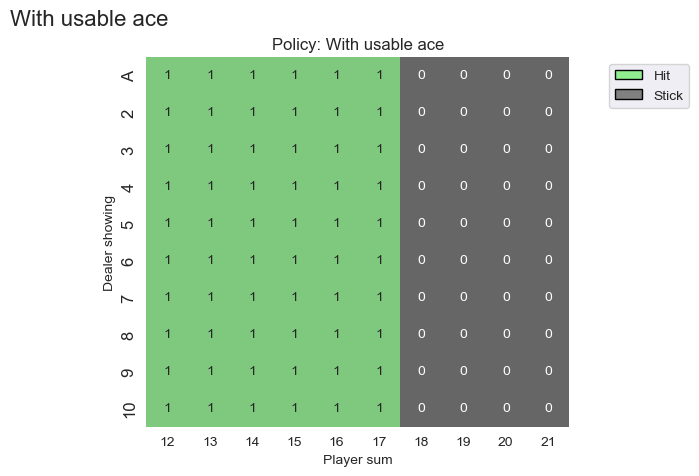

In [5]:
# plot policy matrix with ace
policy_grid = neatHelpers.create_grids(winner, config, usable_ace=True)
fig1 = neatHelpers.create_plots(policy_grid, title="With usable ace")
plt.show()

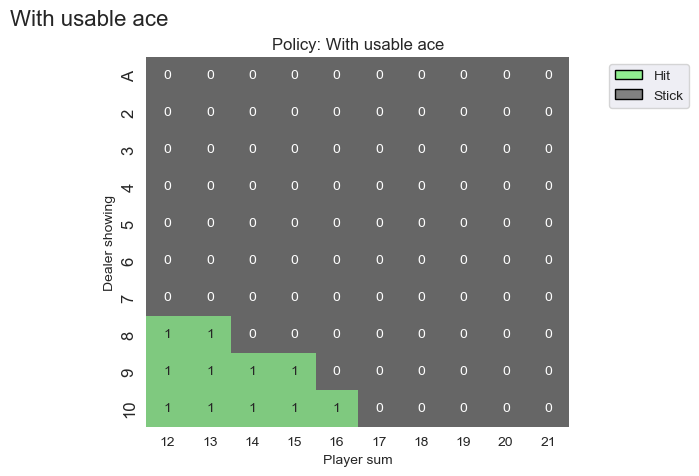

In [15]:
# plot policy matrix without ace
policy_grid = neatHelpers.create_grids(winner, config, usable_ace=True)
fig1 = neatHelpers.create_plots(policy_grid, title="Without usable ace")
plt.show()

In [ ]:
rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()